# Demand Forecasting & Inventory Optimization for DataCo Global

## Notebook 03: Forecasting Models

---

**Project:** End-to-End Supply Chain Analytics  
**Dataset:** DataCo Smart Supply Chain Dataset  

---

### Notebook Series

| Notebook | Description | Status |
|----------|-------------|--------|
| 01_Data_Cleaning | Data loading, cleaning, validation | Complete |
| 02_EDA_ABC_XYZ | Exploratory analysis, product segmentation | Complete |
| **03_Forecasting_Models** | Demand forecasting model development | Current |
| 04_Inventory_Optimization | Safety stock and reorder point | Next |

### Objectives

**Part A - Model Selection (Aggregate Demand)**
1. Analyze data patterns to justify model choice
2. Compare 3 simple models: Naive, Moving Average, Exponential Smoothing
3. Select best performing model

**Part B - Product Forecasting (AX Products)**
1. Apply winning model to top 6 revenue products
2. Generate forecasts for inventory planning

### Table of Contents

**Part A: Model Selection**
1. [Setup & Data Loading](#1-setup--data-loading)
2. [Data Pattern Analysis](#2-data-pattern-analysis)
3. [Train/Test Split](#3-traintest-split)
4. [Model Building & Comparison](#4-model-building--comparison)

**Part B: AX Product Forecasts**
5. [AX Product Identification](#5-ax-product-identification)
6. [Product-Level Forecasting](#6-product-level-forecasting)
7. [Results & Conclusions](#7-results--conclusions)

---

# Part A: Model Selection

We first analyze aggregate (total) demand to select the best forecasting approach.

## 1. Setup & Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load cleaned data
df = pd.read_csv('data/processed/df_clean_filtered.csv')
df['order date (DateOrders)'] = pd.to_datetime(df['order date (DateOrders)'])

print(f"Records: {len(df):,}")
print(f"Date Range: {df['order date (DateOrders)'].min().date()} to {df['order date (DateOrders)'].max().date()}")

Records: 75,564
Date Range: 2015-01-01 to 2017-10-07


In [2]:
# Aggregate to weekly demand
weekly_demand = df.resample('W', on='order date (DateOrders)')['Order Item Quantity'].sum()

print(f"Total Weeks: {len(weekly_demand)}")
print(f"\nFirst 5 weeks:\n{weekly_demand.head()}")
print(f"\nLast 5 weeks:\n{weekly_demand.tail()}")

Total Weeks: 145

First 5 weeks:
order date (DateOrders)
2015-01-04     622
2015-01-11    1139
2015-01-18    1226
2015-01-25    1162
2015-02-01    1219
Freq: W-SUN, Name: Order Item Quantity, dtype: int64

Last 5 weeks:
order date (DateOrders)
2017-09-10    1177
2017-09-17    1089
2017-09-24    1136
2017-10-01    1075
2017-10-08     232
Freq: W-SUN, Name: Order Item Quantity, dtype: int64


## 2. Data Pattern Analysis

Before choosing models, we analyze three key patterns to justify our approach:
1. **Variability (CV)** - How stable is demand?
2. **Trend** - Is demand increasing/decreasing?
3. **Seasonality** - Are there repeating patterns?

### 2.1 Variability Analysis (CV)

In [3]:
# Calculate Coefficient of Variation
mean_demand = weekly_demand.mean()
std_demand = weekly_demand.std()
cv = (std_demand / mean_demand) * 100

print(f"Mean: {mean_demand:.0f} units/week")
print(f"Std Dev: {std_demand:.0f} units")
print(f"CV: {cv:.1f}%")
print(f"\nConclusion: {'Low' if cv < 20 else 'Moderate' if cv < 50 else 'High'} variability")

Mean: 1135 units/week
Std Dev: 127 units
CV: 11.1%

Conclusion: Low variability


### 2.2 Trend Analysis

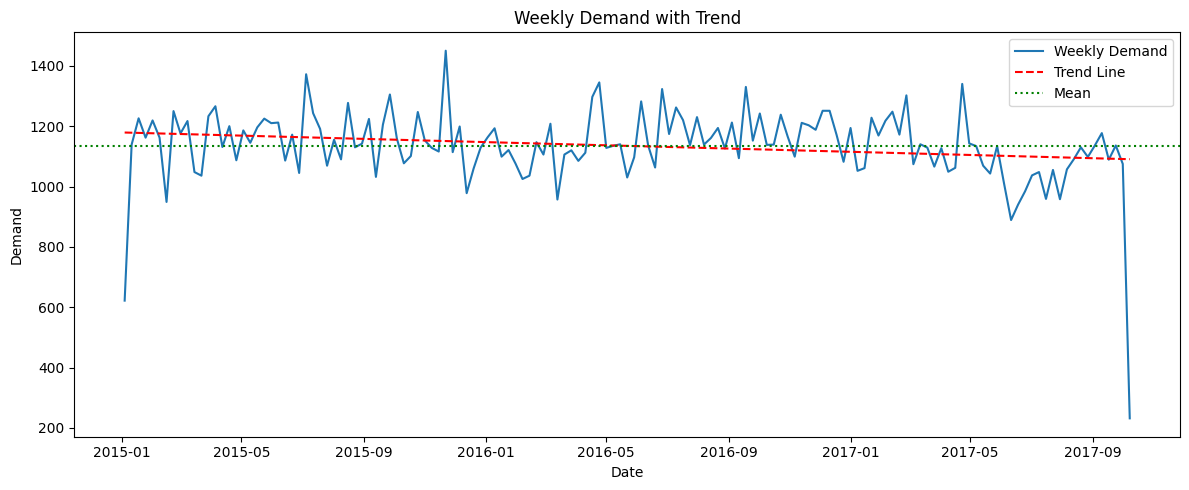

Trend slope: -0.61 units/week
Conclusion: Flat (no trend)


In [4]:
# Calculate trend line
x = np.arange(len(weekly_demand))
slope, intercept = np.polyfit(x, weekly_demand.values, 1)
trend = slope * x + intercept

# Plot
plt.figure(figsize=(12, 5))
plt.plot(weekly_demand.index, weekly_demand, label='Weekly Demand')
plt.plot(weekly_demand.index, trend, 'r--', label='Trend Line')
plt.axhline(weekly_demand.mean(), color='green', linestyle=':', label='Mean')
plt.title('Weekly Demand with Trend')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.tight_layout()
plt.show()

# Interpretation
print(f"Trend slope: {slope:.2f} units/week")
print(f"Conclusion: {'Flat (no trend)' if abs(slope) < 1 else 'Upward trend' if slope > 0 else 'Downward trend'}")

### 2.3 Seasonality Analysis

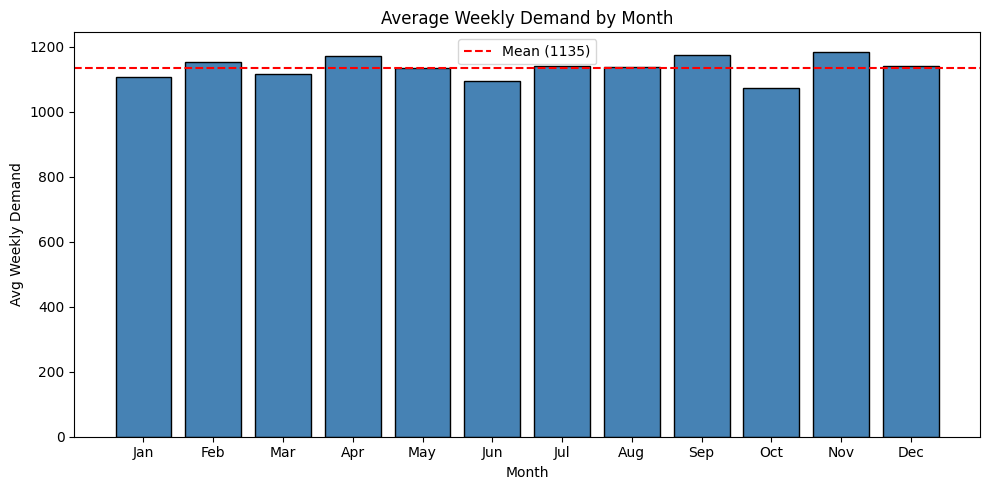

Seasonal variation: 9.8% of mean
Conclusion: Weak seasonality


In [5]:
# Monthly pattern analysis
monthly_pattern = weekly_demand.groupby(weekly_demand.index.month).mean()

# Plot
plt.figure(figsize=(10, 5))
plt.bar(monthly_pattern.index, monthly_pattern.values, color='steelblue', edgecolor='black')
plt.axhline(weekly_demand.mean(), color='red', linestyle='--', label=f'Mean ({weekly_demand.mean():.0f})')
plt.title('Average Weekly Demand by Month')
plt.xlabel('Month')
plt.ylabel('Avg Weekly Demand')
plt.xticks(range(1, 13), ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.legend()
plt.tight_layout()
plt.show()

# Calculate seasonality strength
seasonal_range = monthly_pattern.max() - monthly_pattern.min()
seasonal_pct = (seasonal_range / weekly_demand.mean()) * 100

print(f"Seasonal variation: {seasonal_pct:.1f}% of mean")
print(f"Conclusion: {'Weak' if seasonal_pct < 20 else 'Moderate' if seasonal_pct < 40 else 'Strong'} seasonality")

### Pattern Analysis Summary

| Check | Result | Conclusion |
|-------|--------|------------|
| Variability (CV) | 11.1% | Low - Simple models sufficient |
| Trend | -0.61 slope | Flat - No trend models needed |
| Seasonality | 9.8% variation | Weak - No seasonal models needed |

**Decision:** Use simple models (Naive, Moving Average, Exponential Smoothing).  
Complex models (ARIMA, Holt-Winters, ML) are not needed for this stable demand pattern.

## 3. Train/Test Split

**Why 80/20 time-based split?**
- 80% (116 weeks) to learn patterns
- 20% (29 weeks) to evaluate accuracy
- Time-based (not random) to simulate real forecasting

Train: 116 weeks | Test: 29 weeks


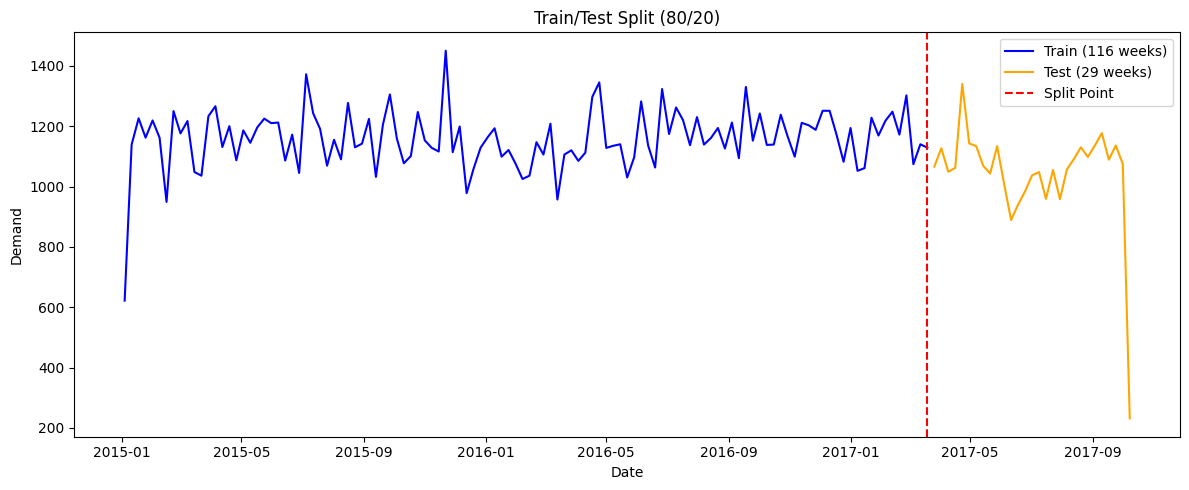

In [6]:
# Train/Test Split (80/20)
split_point = int(len(weekly_demand) * 0.8)
train = weekly_demand[:split_point]
test = weekly_demand[split_point:]

print(f"Train: {len(train)} weeks | Test: {len(test)} weeks")

# Visualize split
plt.figure(figsize=(12, 5))
plt.plot(train.index, train.values, label=f'Train ({len(train)} weeks)', color='blue')
plt.plot(test.index, test.values, label=f'Test ({len(test)} weeks)', color='orange')
plt.axvline(x=train.index[-1], color='red', linestyle='--', label='Split Point')
plt.title('Train/Test Split (80/20)')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.tight_layout()
plt.show()

## 4. Model Building & Comparison

We compare three simple forecasting models:

| Model | Logic |
|-------|-------|
| **Naive** | Forecast = Last actual value |
| **Moving Average** | Forecast = Average of last N weeks |
| **Exponential Smoothing** | Forecast = Weighted average (recent data weighted more) |

### 4.1 Naive Forecast

In [7]:
# Naive Forecast: Each prediction = previous actual value
naive_forecast = [train.iloc[-1]]  # First forecast = last training value
for i in range(1, len(test)):
    naive_forecast.append(test.iloc[i-1])
naive_forecast = pd.Series(naive_forecast, index=test.index)

print("Naive Forecast (First 5 weeks):")
print(pd.DataFrame({'Actual': test.head(), 'Forecast': naive_forecast.head()}))

Naive Forecast (First 5 weeks):
                         Actual  Forecast
order date (DateOrders)                  
2017-03-26                 1066      1129
2017-04-02                 1127      1066
2017-04-09                 1049      1127
2017-04-16                 1062      1049
2017-04-23                 1340      1062


### 4.2 Moving Average Forecast

In [8]:
# Moving Average Forecast (window = 4 weeks)
window = 4
ma_forecast = []
for i in range(len(test)):
    if i == 0:
        avg = train.iloc[-window:].mean()
    else:
        all_data = pd.concat([train, test.iloc[:i]])
        avg = all_data.iloc[-window:].mean()
    ma_forecast.append(avg)
ma_forecast = pd.Series(ma_forecast, index=test.index)

print("Moving Average Forecast (First 5 weeks):")
print(pd.DataFrame({'Actual': test.head(), 'Forecast': ma_forecast.head().round(0)}))

Moving Average Forecast (First 5 weeks):
                         Actual  Forecast
order date (DateOrders)                  
2017-03-26                 1066    1161.0
2017-04-02                 1127    1102.0
2017-04-09                 1049    1116.0
2017-04-16                 1062    1093.0
2017-04-23                 1340    1076.0


### 4.3 Simple Exponential Smoothing

In [9]:
# Simple Exponential Smoothing (alpha = 0.6)
alpha = 0.6
ses_forecast = []
last_forecast = train.iloc[-1]
for i in range(len(test)):
    if i == 0:
        forecast = last_forecast
    else:
        forecast = alpha * test.iloc[i-1] + (1 - alpha) * last_forecast
    ses_forecast.append(forecast)
    last_forecast = forecast
ses_forecast = pd.Series(ses_forecast, index=test.index)

print("SES Forecast (First 5 weeks):")
print(pd.DataFrame({'Actual': test.head(), 'Forecast': ses_forecast.head().round(0)}))

SES Forecast (First 5 weeks):
                         Actual  Forecast
order date (DateOrders)                  
2017-03-26                 1066    1129.0
2017-04-02                 1127    1091.0
2017-04-09                 1049    1113.0
2017-04-16                 1062    1074.0
2017-04-23                 1340    1067.0


### 4.4 Model Comparison

In [10]:
# Calculate MAPE for each model
def calculate_mape(actual, forecast):
    return (abs(actual - forecast) / actual).mean() * 100

mape_naive = calculate_mape(test, naive_forecast)
mape_ma = calculate_mape(test, ma_forecast)
mape_ses = calculate_mape(test, ses_forecast)

# Calculate MAE
mae_naive = abs(test - naive_forecast).mean()
mae_ma = abs(test - ma_forecast).mean()
mae_ses = abs(test - ses_forecast).mean()

# Results
print("Model Comparison (Lower is Better)")
print("=" * 45)
print(f"{'Model':<20} {'MAE':>10} {'MAPE':>12}")
print("-" * 45)
print(f"{'Naive':<20} {mae_naive:>10.0f} {mape_naive:>11.2f}%")
print(f"{'Moving Average (4)':<20} {mae_ma:>10.0f} {mape_ma:>11.2f}%")
print(f"{'SES (α=0.6)':<20} {mae_ses:>10.0f} {mape_ses:>11.2f}%")
print("-" * 45)
print(f"\n🏆 Winner: SES with lowest MAPE ({mape_ses:.2f}%)")

Model Comparison (Lower is Better)
Model                       MAE         MAPE
---------------------------------------------
Naive                       100       19.06%
Moving Average (4)           97       19.39%
SES (α=0.6)                  94       18.75%
---------------------------------------------

🏆 Winner: SES with lowest MAPE (18.75%)


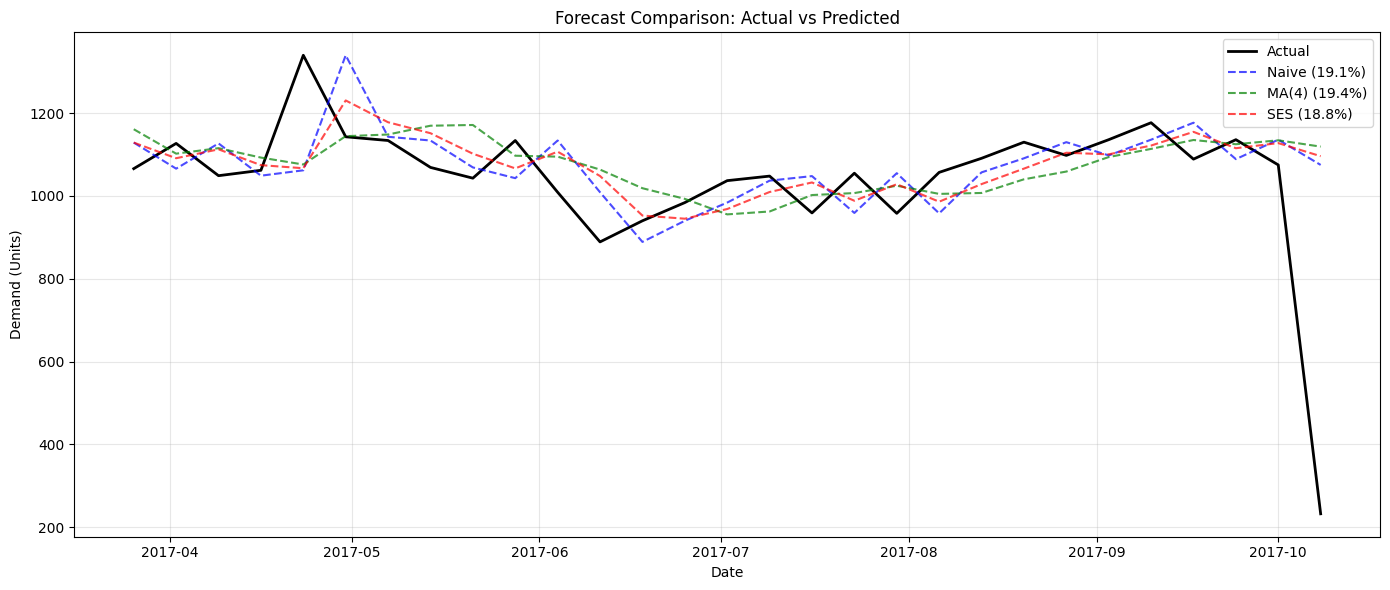

In [11]:
# Visualize forecasts
plt.figure(figsize=(14, 6))
plt.plot(test.index, test.values, 'k-', label='Actual', linewidth=2)
plt.plot(test.index, naive_forecast.values, 'b--', label=f'Naive ({mape_naive:.1f}%)', alpha=0.7)
plt.plot(test.index, ma_forecast.values, 'g--', label=f'MA(4) ({mape_ma:.1f}%)', alpha=0.7)
plt.plot(test.index, ses_forecast.values, 'r--', label=f'SES ({mape_ses:.1f}%)', alpha=0.7)
plt.title('Forecast Comparison: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Demand (Units)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Part A Summary: Model Selection Results

| Model | MAE (units) | MAPE (%) |
|-------|-------------|----------|
| Naive | 100 | 19.06 |
| Moving Average (4) | 97 | 19.39 |
| **SES (α=0.6)** | **94** | **18.75** |

**Winner:** Simple Exponential Smoothing (SES)

**Why SES wins:** Balances reactivity (follows trends) with smoothness (ignores noise).  
Naive overreacts to spikes; MA is too slow to respond.

---

# Part B: AX Product Forecasts

Now we apply SES to individual AX products (high value + stable demand) from ABC-XYZ analysis.

## 5. AX Product Identification

In [12]:
# Load ABC-XYZ results
abc_xyz_df = pd.read_csv('outputs/abc_xyz_results.csv')
ax_products = abc_xyz_df[abc_xyz_df['Segment'] == 'AX']

print(f"AX Products: {len(ax_products)} products | Revenue: ${ax_products['Revenue'].sum():,.0f} ({ax_products['Revenue'].sum() / abc_xyz_df['Revenue'].sum() * 100:.1f}%)")
print("\nProduct List:")
print(ax_products[['Product Name', 'Revenue', 'CV']].to_string(index=False))

AX Products: 6 products | Revenue: $11,106,578 (74.3%)

Product List:
                                 Product Name      Revenue   CV
    Field & Stream Sportsman 16 Gun Fire Safe 3.022249e+06 0.16
             Perfect Fitness Perfect Rip Deck 1.929578e+06 0.16
Diamondback Women's Serene Classic Comfort Bi 1.802880e+06 0.19
            Nike Men's Free 5.0+ Running Shoe 1.627337e+06 0.22
         Nike Men's Dri-FIT Victory Golf Polo 1.387000e+06 0.18
                  Pelican Sunstream 100 Kayak 1.337533e+06 0.18


## 6. Product-Level Forecasting

In [13]:
# Prepare weekly demand for each AX product
ax_product_names = ax_products['Product Name'].tolist()
product_weekly_demand = {}

for product in ax_product_names:
    product_data = df[df['Product Name'] == product]
    weekly = product_data.resample('W', on='order date (DateOrders)')['Order Item Quantity'].sum()
    product_weekly_demand[product] = weekly

# Fill missing weeks with 0
full_index = product_weekly_demand['Perfect Fitness Perfect Rip Deck'].index
for product in ax_product_names:
    product_weekly_demand[product] = product_weekly_demand[product].reindex(full_index, fill_value=0)

print("Weekly demand prepared for all AX products (145 weeks each)")

Weekly demand prepared for all AX products (145 weeks each)


In [14]:
# Forecast function
def forecast_product(weekly_demand, alpha=0.6, test_size=0.2):
    # Split
    split_point = int(len(weekly_demand) * (1 - test_size))
    train = weekly_demand[:split_point]
    test = weekly_demand[split_point:]
    
    # SES Forecast
    forecast = []
    last_forecast = train.iloc[-1]
    for i in range(len(test)):
        if i == 0:
            pred = last_forecast
        else:
            pred = alpha * test.iloc[i-1] + (1 - alpha) * last_forecast
        forecast.append(pred)
        last_forecast = pred
    forecast = pd.Series(forecast, index=test.index)
    
    # Metrics (exclude anomaly week 2017-10-08)
    test_clean = test[test.index != '2017-10-08']
    forecast_clean = forecast[forecast.index != '2017-10-08']
    non_zero = test_clean != 0
    mape = (abs(test_clean[non_zero] - forecast_clean[non_zero]) / test_clean[non_zero]).mean() * 100
    mae = abs(test - forecast).mean()
    
    return {'test': test, 'forecast': forecast, 'mae': mae, 'mape': mape, 'avg': weekly_demand.mean()}

In [15]:
# Run forecasts for all AX products
results = {}
print("AX Products Forecast Results (SES α=0.6)")
print("=" * 65)
print(f"{'Product':<40} {'Avg Demand':>10} {'MAE':>8} {'MAPE':>8}")
print("-" * 65)

for product in ax_product_names:
    result = forecast_product(product_weekly_demand[product])
    results[product] = result
    print(f"{product[:39]:<40} {result['avg']:>10.1f} {result['mae']:>8.1f} {result['mape']:>7.1f}%")

print("-" * 65)
print("Note: MAPE excludes anomaly week (2017-10-08)")

AX Products Forecast Results (SES α=0.6)
Product                                  Avg Demand      MAE     MAPE
-----------------------------------------------------------------
Field & Stream Sportsman 16 Gun Fire Sa        52.1      9.6    14.6%
Perfect Fitness Perfect Rip Deck              221.8     32.1    12.3%
Diamondback Women's Serene Classic Comf        41.4      8.4    18.7%
Nike Men's Free 5.0+ Running Shoe             112.2     23.4    17.6%
Nike Men's Dri-FIT Victory Golf Polo          191.3     28.3    12.7%
Pelican Sunstream 100 Kayak                    46.1      8.8    17.2%
-----------------------------------------------------------------
Note: MAPE excludes anomaly week (2017-10-08)


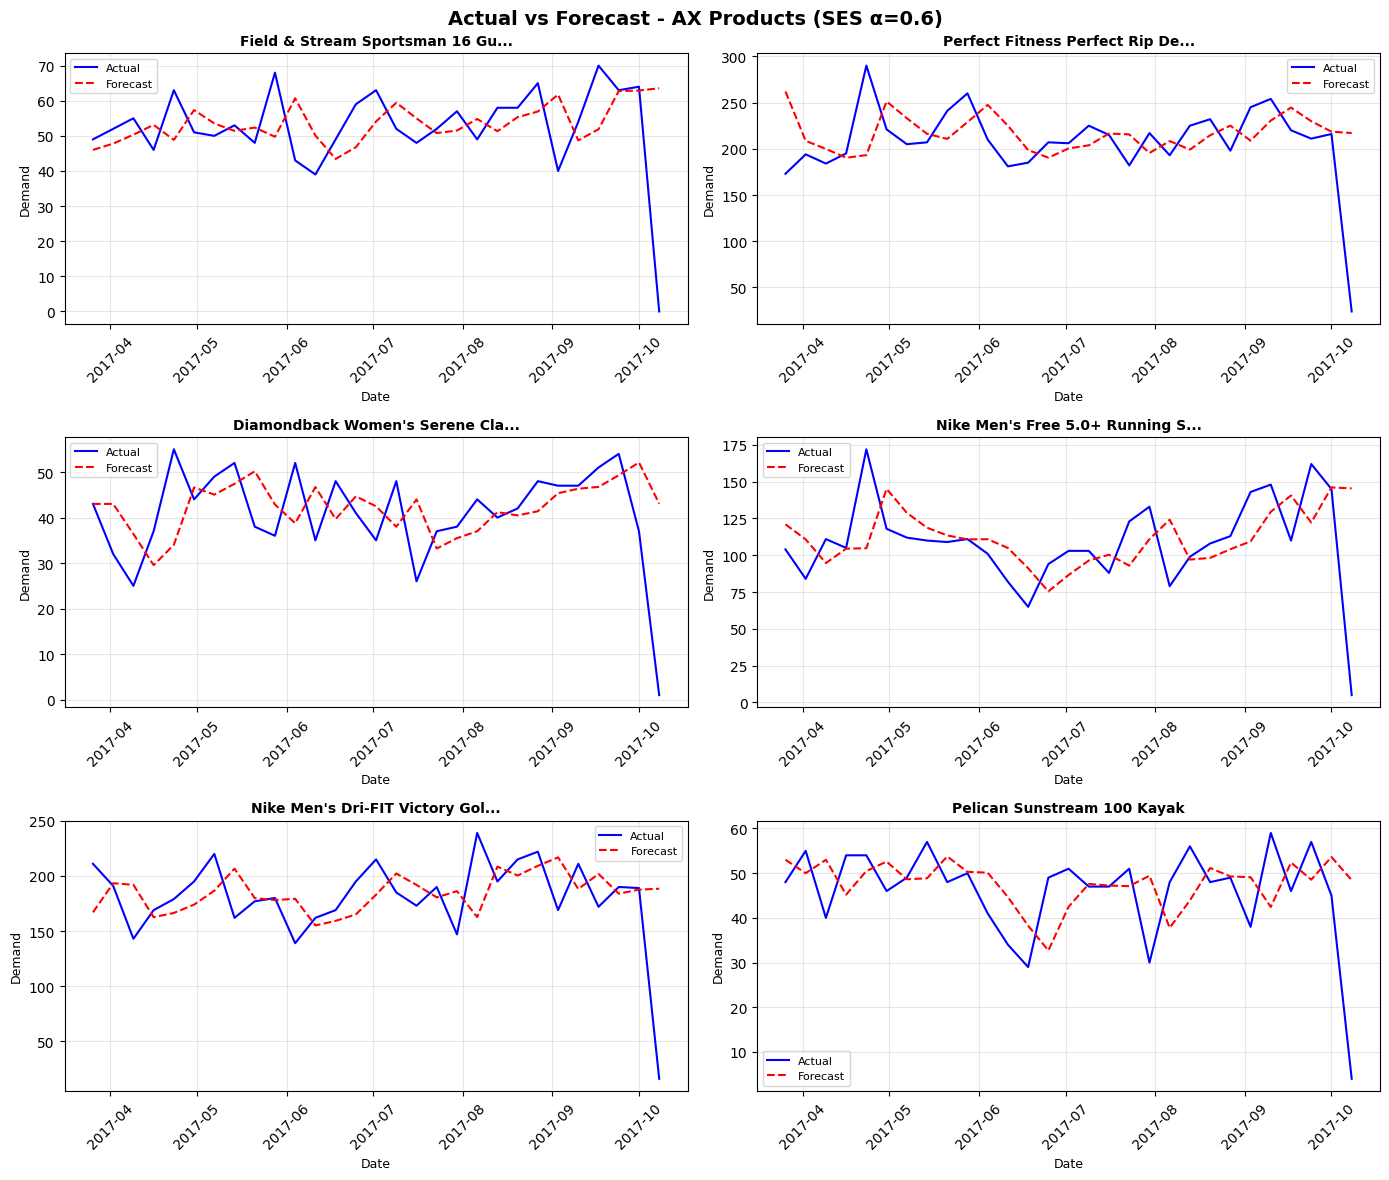

In [16]:
# Visualize all product forecasts
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, product in enumerate(ax_product_names):
    result = results[product]
    ax = axes[idx]
    ax.plot(result['test'].index, result['test'].values, 'b-', label='Actual', linewidth=1.5)
    ax.plot(result['forecast'].index, result['forecast'].values, 'r--', label='Forecast', linewidth=1.5)
    short_name = product[:30] + '...' if len(product) > 30 else product
    ax.set_title(short_name, fontsize=10, fontweight='bold')
    ax.set_xlabel('Date', fontsize=9)
    ax.set_ylabel('Demand', fontsize=9)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.suptitle('Actual vs Forecast - AX Products (SES α=0.6)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. Results & Conclusions

### Part A: Aggregate Demand Model Selection

**Data Analysis Results:**
| Check | Result | Conclusion |
|-------|--------|------------|
| Variability (CV) | 11.1% | Low → Simple models work |
| Trend | -0.61 (Flat) | No trend models needed |
| Seasonality | 9.8% | Weak → No seasonal models needed |

**Model Comparison:**
| Model | MAE (units) | MAPE (%) |
|-------|-------------|----------|
| Naive | 100 | 19.06 |
| Moving Average (4) | 97 | 19.39 |
| **SES (α=0.6)** | **94** | **18.75** |

**Winner:** SES — balances reactivity with smoothness.

---

### Part B: AX Product Forecasts

| Product | Avg Weekly Demand | MAE | MAPE |
|---------|-------------------|-----|------|
| Field & Stream Gun Safe | 52.1 | 9.6 | 14.6% |
| Perfect Fitness Rip Deck | 221.8 | 32.1 | 12.3% |
| Diamondback Bike | 41.4 | 8.4 | 18.7% |
| Nike Running Shoe | 112.2 | 23.4 | 17.6% |
| Nike Golf Polo | 191.3 | 28.3 | 12.7% |
| Pelican Kayak | 46.1 | 8.8 | 17.2% |

**Key Finding:** All AX products achieve 12-19% MAPE (Good accuracy).

---

### Key Takeaways

1. **Simple models work well** for stable demand (CV < 20%)
2. **SES outperforms** Naive and MA by balancing reactivity and smoothness
3. **AX products (74% of revenue)** can be accurately forecasted with ~15% MAPE
4. **Anomaly handling** is critical — one bad week can distort MAPE significantly

---

**Next:** Notebook 04 - Inventory Optimization (Safety Stock & Reorder Points)